# Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

### Load files

In [10]:
bcast_files = {
    "Default": "../results_model/bcast_default.csv",
    "Basic Linear": "../results_model/bcast_algo1.csv",
    "Chain": "../results/bcast_algo2_all.csv",
    "Pipeline": "../results_model/bcast_algo3.csv",
    "Binomial": "../results_model/bcast_algo6.csv"
}

reduce_files = {
    "Default": "../results_model/reduce_default.csv",
    "Linear": "../results_model/reduce_algo1.csv",
    "Binomial": "../results_model/reduce_algo5.csv",
    "Rabenseifner": "../results_model/reduce_algo7.csv"
}


## Broadcast

The three algorithms:
- basic_linear (1),
- pipeline (3),
- binomial (6).

## Latency 

In [193]:
combined_latencies = {
    1: 0.15,     # Same CCX
    4: 0.32,     # CCD / diff CCX
    8: 0.35,     # Same NUMA domain
    32: 0.43,    # Cross NUMA
    64: 0.69,    # Cross socket
    128: 2.82    # Inter-node
}


def get_latency(core_distance):
    try:
        core_distance = int(core_distance)
    except:
        return combined_latencies[1]  # Fallback to lowest

    for k in sorted(combined_latencies.keys(), reverse=True):
        if core_distance >= k:
            return combined_latencies[k]
    return combined_latencies[1]

In [210]:
N = 256
cores_per_node = 128
latency_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if i == j:
            latency_matrix[i][j] = 0
        elif i // 4 == j // 4:
            latency_matrix[i][j] = 0.15  # Same CCX
        elif i // 16 == j // 16:
            latency_matrix[i][j] = 0.32  # Diff CCX
        elif i // 32 == j // 32:
            latency_matrix[i][j] = 0.35  # Same NUMA
        elif i // 64 == j // 64:
            latency_matrix[i][j] = 0.43  # Cross NUMA
        elif i // 128 == j // 128:
            latency_matrix[i][j] = 0.69  # Same node, other socket
        else:
            latency_matrix[i][j] = 2.82  # Inter-node (cross node boundary)


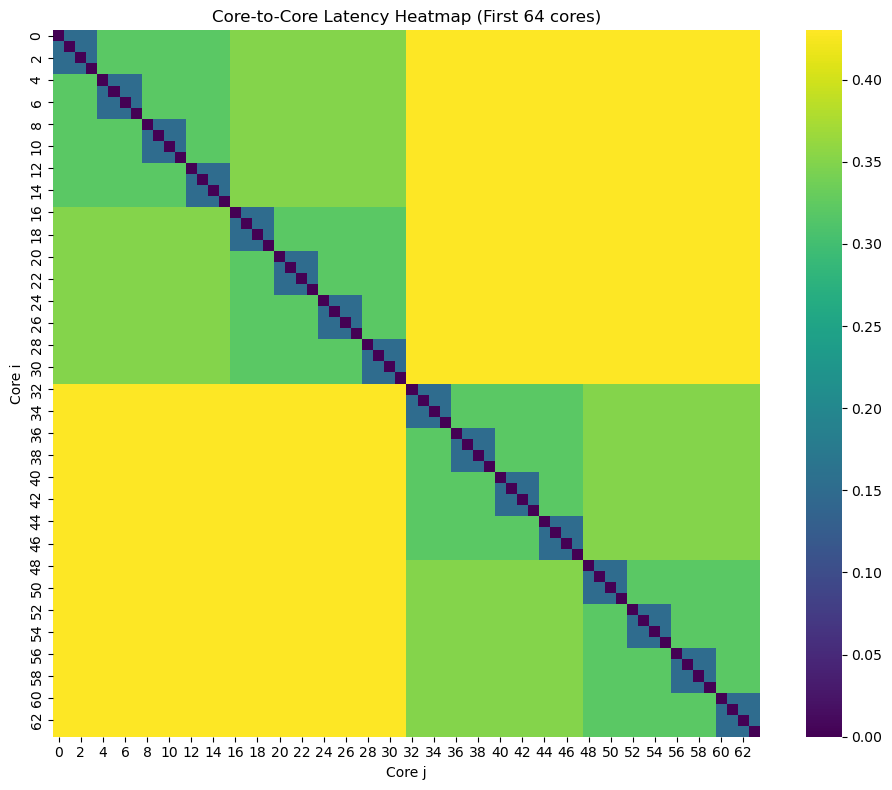

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(latency_matrix[:64, :64], cmap="viridis", square=True)
plt.title("Core-to-Core Latency Heatmap (First 64 cores)")
plt.xlabel("Core j")
plt.ylabel("Core i")
plt.tight_layout()
plt.show()


## Bcsat models

### Basic linear

In [212]:
def model_flat_tree_latency(P):
    if P <= 1:
        return 0
    return sum(latency_matrix[0][1:P])


df_flat = pd.read_csv("../results_model/bcast_algo1.csv")
df_flat.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]


df_flat["Processes"] = pd.to_numeric(df_flat["Processes"], errors="coerce")
df_flat["Size"] = pd.to_numeric(df_flat["Size"], errors="coerce")
df_flat["Latency(us)"] = pd.to_numeric(df_flat["Latency(us)"], errors="coerce")



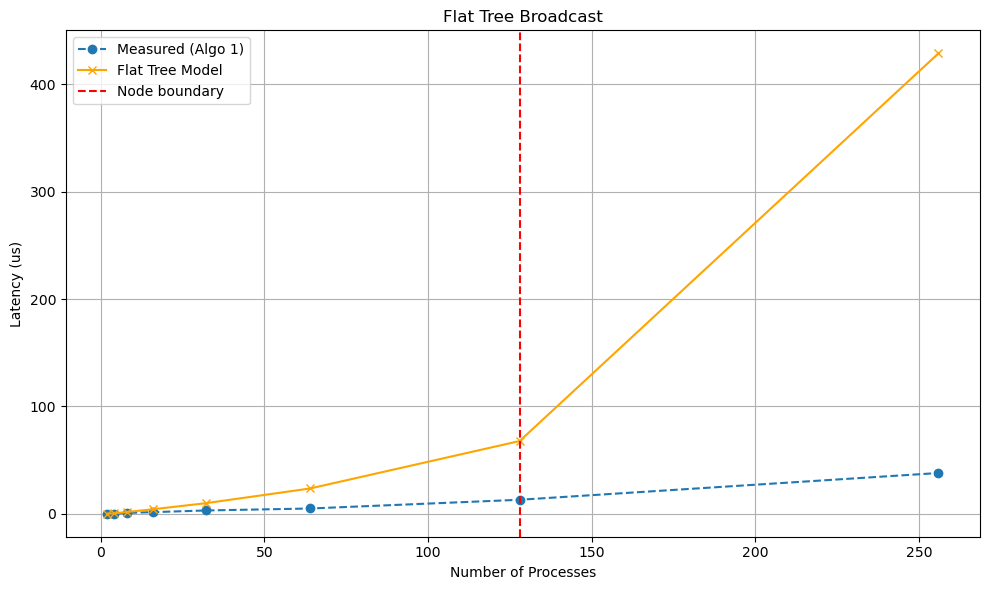

In [213]:
df_plot = df_flat[df_flat["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]
df_plot["Flat Tree Model (us)"] = df_plot["Processes"].apply(model_flat_tree_latency)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Algo 1)")

plt.plot(df_plot["Processes"], df_plot["Flat Tree Model (us)"],
         marker='x', linestyle='-', color='orange', label="Flat Tree Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Flat Tree Broadcast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 

### Pipeline

In [214]:
def model_pipeline_latency(P):
    if P <= 1:
        return 0
    # One segment must traverse the whole chain
    base_time = sum(latency_matrix[i][i+1] for i in range(P - 1))
    return base_time 

df_pipeline = pd.read_csv(bcast_files["Pipeline"])
df_pipeline.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

df_pipeline["Processes"] = pd.to_numeric(df_pipeline["Processes"], errors="coerce")
df_pipeline["Size"] = pd.to_numeric(df_pipeline["Size"], errors="coerce")
df_pipeline["Latency(us)"] = pd.to_numeric(df_pipeline["Latency(us)"], errors="coerce")

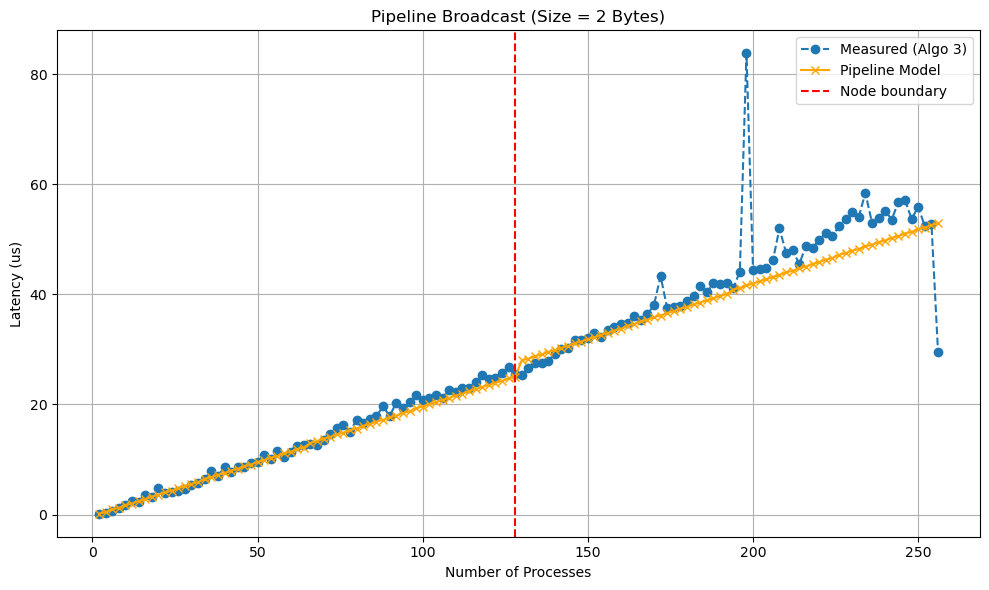

In [215]:
size_chosen = 2
df_pipe_plot = df_pipeline[df_pipeline["Size"] == size_chosen].copy()
df_pipe_plot = df_pipe_plot[df_pipe_plot["Processes"] <= 256]

df_pipe_plot["Pipeline Model (us)"] = df_pipe_plot["Processes"].apply(model_pipeline_latency)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Algo 3)")
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Pipeline Model (us)"],
         marker='x', linestyle='-', color='orange', label="Pipeline Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Pipeline Broadcast (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Binomial tree

In [216]:
df_binomial = pd.read_csv(bcast_files["Binomial"])
df_binomial.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

df_binomial["Processes"] = pd.to_numeric(df_binomial["Processes"], errors="coerce")
df_binomial["Size"] = pd.to_numeric(df_binomial["Size"], errors="coerce")
df_binomial["Latency(us)"] = pd.to_numeric(df_binomial["Latency(us)"], errors="coerce")



In [217]:
def model_binomial_latency(P):
    if P <= 1:
        return 0
    steps = math.ceil(math.log2(P))
    
    total = 0
    for i in range(steps):
        dist = 2**i
        if dist >= P:
            break
        total += get_latency(dist)
    
    return total 
    

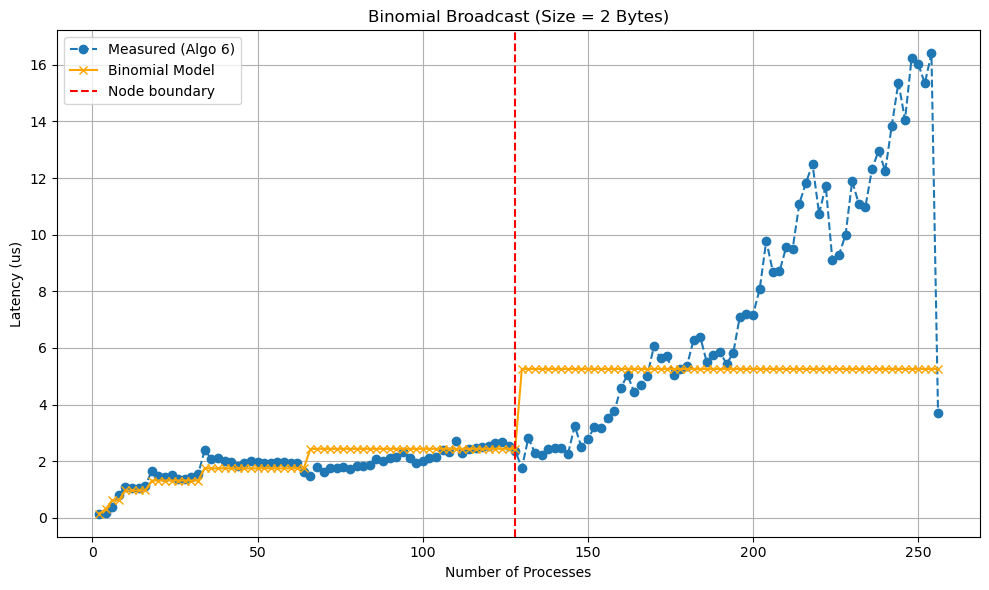

In [218]:
size_chosen = 2
df_bin_plot = df_binomial[df_binomial["Size"] == size_chosen].copy()
df_bin_plot = df_bin_plot[df_bin_plot["Processes"] <= 256]

df_bin_plot["Binomial Model (us)"] = df_bin_plot["Processes"].apply(model_binomial_latency)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_bin_plot["Processes"], df_bin_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Algo 6)")
plt.plot(df_bin_plot["Processes"], df_bin_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Binomial Broadcast (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Chain

In [363]:
def chain_bcast_model(P):
    if P <= 1:
        return 0
    base = sum(latency_matrix[i][i + 1] for i in range(P - 1))
    return base   # 10% overhead for slower scheduling


In [366]:
def chain_bcast_model(P, fixed_fanout=4, cores_per_node=128):
    if P <= 1:
        return 0

    processes = list(range(1, P))  # assuming root is core 0
    base_chain_size = len(processes) // fixed_fanout
    remainder = len(processes) % fixed_fanout
    start = 0
    latencies = []

    for chain in range(fixed_fanout):
        size = base_chain_size + (1 if chain < remainder else 0)
        end = start + size
        chain_proc = processes[start:end]
        if not chain_proc:
            continue

        # First hop from root
        chain_latency = latency_matrix[0][chain_proc[0]]
        for i in range(1, len(chain_proc)):
            chain_latency += latency_matrix[chain_proc[i - 1]][chain_proc[i]]
        latencies.append(chain_latency)
        start = end

    return max(latencies)  # no 1e6 if matrix already in µs


In [367]:
# Read the chain broadcast results
df_chain = pd.read_csv("../results_model/bcast_algo2.csv")
df_chain.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Clean up numeric types
df_chain["Processes"] = pd.to_numeric(df_chain["Processes"], errors="coerce")
df_chain["Size"] = pd.to_numeric(df_chain["Size"], errors="coerce")
df_chain["Latency(us)"] = pd.to_numeric(df_chain["Latency(us)"], errors="coerce")

# Filter for a fixed small message size
df_plot = df_chain[df_chain["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

# Add the model predictions
df_plot["Chain Model"] = df_plot["Processes"].apply(chain_bcast_model)


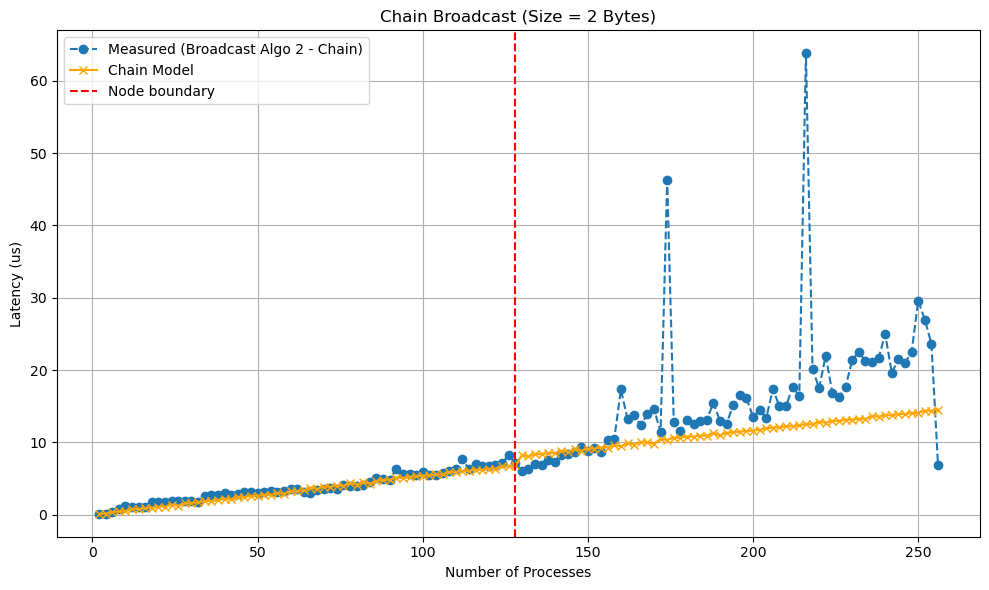

In [368]:
plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Broadcast Algo 2 - Chain)")

plt.plot(df_plot["Processes"], df_plot["Chain Model"],
         marker='x', linestyle='-', color='orange', label="Chain Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Chain Broadcast (Size = 2 Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### All

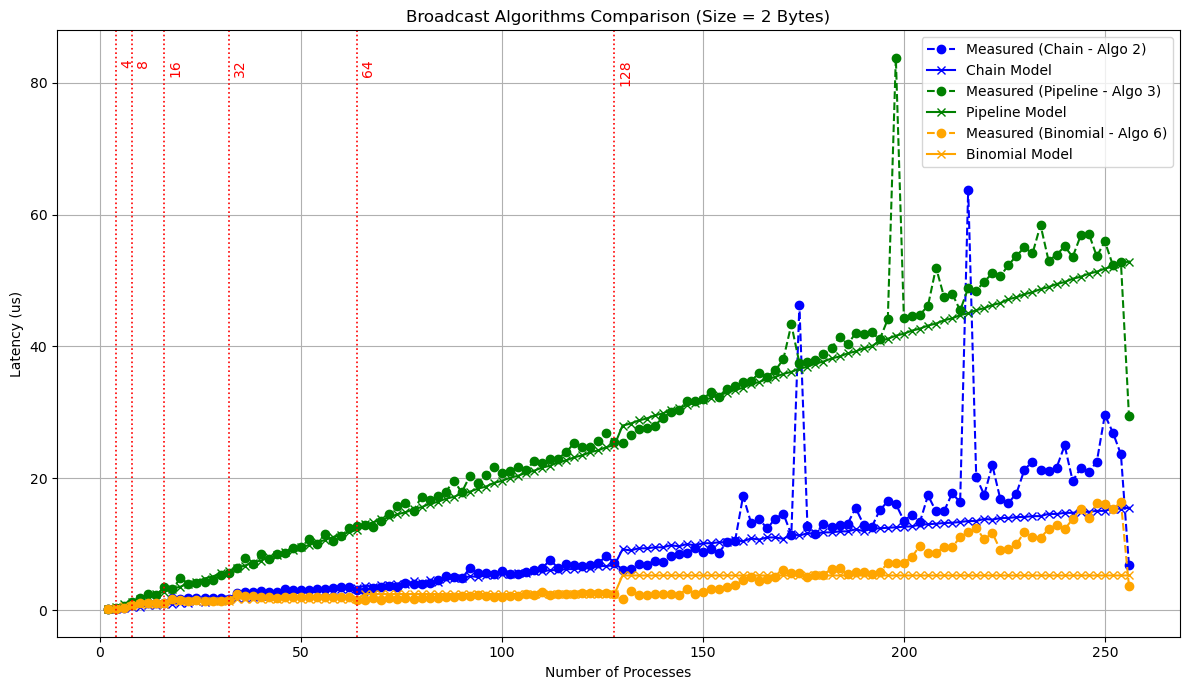

In [223]:
import matplotlib.pyplot as plt

size_chosen = 2

# --- Prepare data ---

# Chain
df_chain_plot = df_chain[df_chain["Size"] == size_chosen].copy()
df_chain_plot = df_chain_plot[df_chain_plot["Processes"] <= 256]
df_chain_plot["Chain Model (us)"] = df_chain_plot["Processes"].apply(chain_bcast_model)

# Pipeline
df_pipe_plot = df_pipeline[df_pipeline["Size"] == size_chosen].copy()
df_pipe_plot = df_pipe_plot[df_pipe_plot["Processes"] <= 256]
df_pipe_plot["Pipeline Model (us)"] = df_pipe_plot["Processes"].apply(model_pipeline_latency)

# Binomial
df_bin_plot = df_binomial[df_binomial["Size"] == size_chosen].copy()
df_bin_plot = df_bin_plot[df_bin_plot["Processes"] <= 256]
df_bin_plot["Binomial Model (us)"] = df_bin_plot["Processes"].apply(model_binomial_latency)

# --- Plot ---

plt.figure(figsize=(12, 7))

# Chain
plt.plot(df_chain_plot["Processes"], df_chain_plot["Latency(us)"],
         marker='o', linestyle='--', color='blue', label="Measured (Chain - Algo 2)")
plt.plot(df_chain_plot["Processes"], df_chain_plot["Chain Model (us)"],
         marker='x', linestyle='-', color='blue', label="Chain Model")

# Pipeline
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Latency(us)"],
         marker='o', linestyle='--', color='green', label="Measured (Pipeline - Algo 3)")
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Pipeline Model (us)"],
         marker='x', linestyle='-', color='green', label="Pipeline Model")

# Binomial
plt.plot(df_bin_plot["Processes"], df_bin_plot["Latency(us)"],
         marker='o', linestyle='--', color='orange', label="Measured (Binomial - Algo 6)")
plt.plot(df_bin_plot["Processes"], df_bin_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Model")

# Add vertical red lines at key core counts
for y in [4, 8, 16, 32, 64, 128]:
    plt.axvline(y, color='red', linestyle=':', linewidth=1.2)
    plt.text(y + 1, plt.ylim()[1] * 0.95, f"{y}", color='red', rotation=90, va='top')

# Final styling
plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Broadcast Algorithms Comparison (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


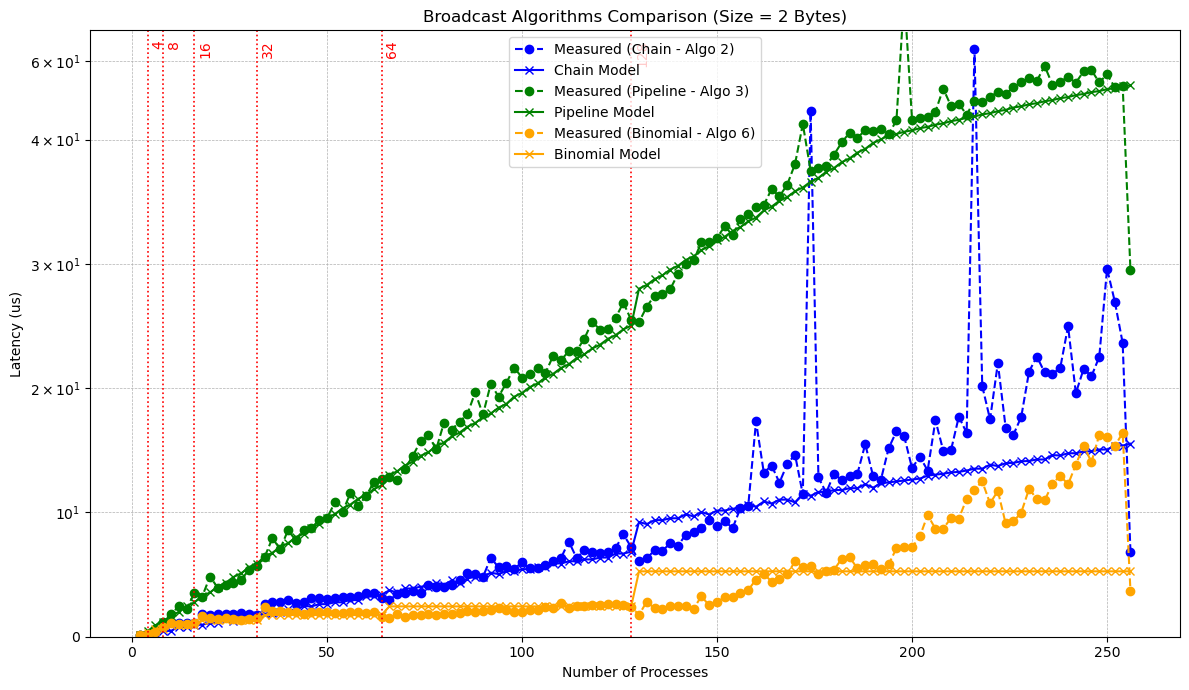

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Chain
plt.plot(df_chain_plot["Processes"], df_chain_plot["Latency(us)"],
         marker='o', linestyle='--', color='blue', label="Measured (Chain - Algo 2)")
plt.plot(df_chain_plot["Processes"], df_chain_plot["Chain Model (us)"],
         marker='x', linestyle='-', color='blue', label="Chain Model")

# Pipeline
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Latency(us)"],
         marker='o', linestyle='--', color='green', label="Measured (Pipeline - Algo 3)")
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Pipeline Model (us)"],
         marker='x', linestyle='-', color='green', label="Pipeline Model")

# Binomial
plt.plot(df_bin_plot["Processes"], df_bin_plot["Latency(us)"],
         marker='o', linestyle='--', color='orange', label="Measured (Binomial - Algo 6)")
plt.plot(df_bin_plot["Processes"], df_bin_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Model")

# Apply symlog scale with lower threshold and custom ticks
plt.yscale('symlog', linthresh=40)

# Set visible, meaningful ticks
custom_ticks = [0, 10, 20, 30, 40, 60, 80, 100, 200, 400, 800, 1600]
plt.yticks(custom_ticks)
plt.ylim(0, max(df_chain_plot["Latency(us)"].max(), df_bin_plot["Latency(us)"].max()) * 1.1)

# Add vertical lines at hierarchy boundaries (not in legend)
for y in [4, 8, 16, 32, 64, 128]:
    plt.axvline(y, color='red', linestyle=':', linewidth=1.2)
    plt.text(y + 1, plt.ylim()[1] * 0.95, f"{y}", color='red', rotation=90, va='top')

# Labels and style
plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Broadcast Algorithms Comparison (Size = 2 Bytes)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Analysis

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

### Load files

In [226]:
bcast_files = {
    "Default": "../results_model/bcast_default.csv",
    "Basic Linear": "../results_model/bcast_algo1.csv",
    "Chain": "../results/bcast_algo2_all.csv",
    "Pipeline": "../results_model/bcast_algo3.csv",
    "Binomial": "../results_model/bcast_algo6.csv"
}

reduce_files = {
    "Default": "../results_model/reduce_default.csv",
    "Linear": "../results_model/reduce_algo1.csv",
    "Binary": "../results_model/reduce_algo4.csv",
    "Binomial": "../results_model/reduce_algo5.csv",
    "Rabenseifner": "../results_model/reduce_algo7.csv"
}


## Broadcast

The three algorithms:
- basic_linear (1),
- pipeline (3),
- binomial (6).

## Latency 

In [227]:
combined_latencies = {
    1: 0.15,     # Same CCX
    4: 0.32,     # CCD / diff CCX
    8: 0.35,     # Same NUMA domain
    32: 0.43,    # Cross NUMA
    64: 0.69,    # Cross socket
    128: 1.82    # Inter-node
}


def get_latency(core_distance):
    try:
        core_distance = int(core_distance)
    except:
        return combined_latencies[1]  # Fallback to lowest

    for k in sorted(combined_latencies.keys(), reverse=True):
        if core_distance >= k:
            return combined_latencies[k]
    return combined_latencies[1]

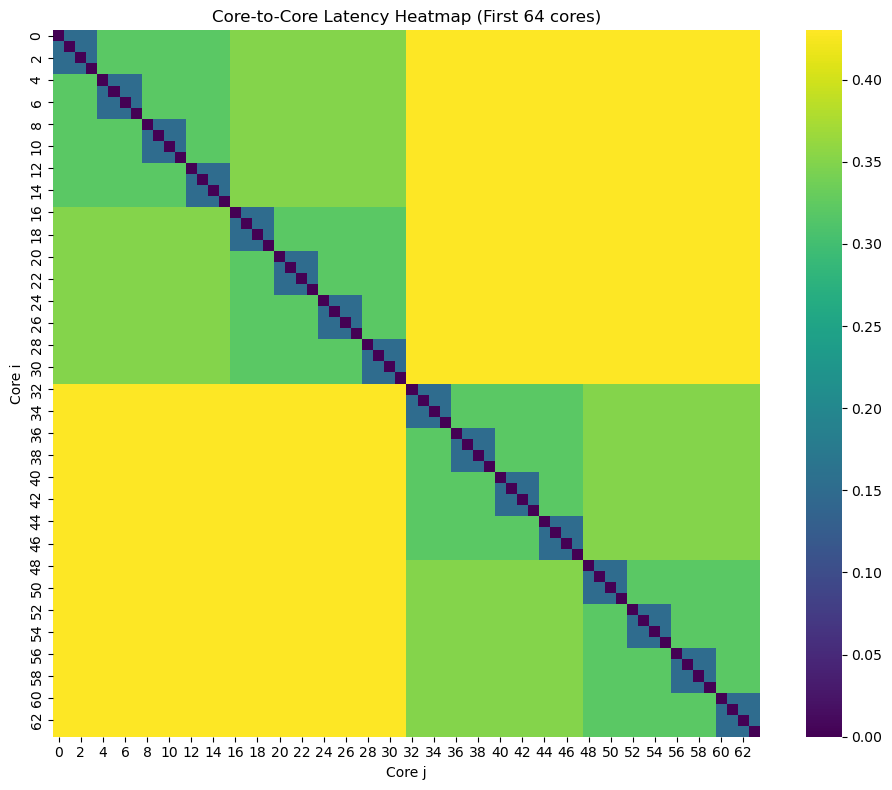

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(latency_matrix[:64, :64], cmap="viridis", square=True)
plt.title("Core-to-Core Latency Heatmap (First 64 cores)")
plt.xlabel("Core j")
plt.ylabel("Core i")
plt.tight_layout()
plt.show()


## Bcsat models

### Basic linear

In [ ]:
def model_flat_tree_latency(P):
    if P <= 1:
        return 0
    return sum(latency_matrix[0][1:P])


df_flat = pd.read_csv("../results_model/bcast_algo1.csv")
df_flat.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]


df_flat["Processes"] = pd.to_numeric(df_flat["Processes"], errors="coerce")
df_flat["Size"] = pd.to_numeric(df_flat["Size"], errors="coerce")
df_flat["Latency(us)"] = pd.to_numeric(df_flat["Latency(us)"], errors="coerce")



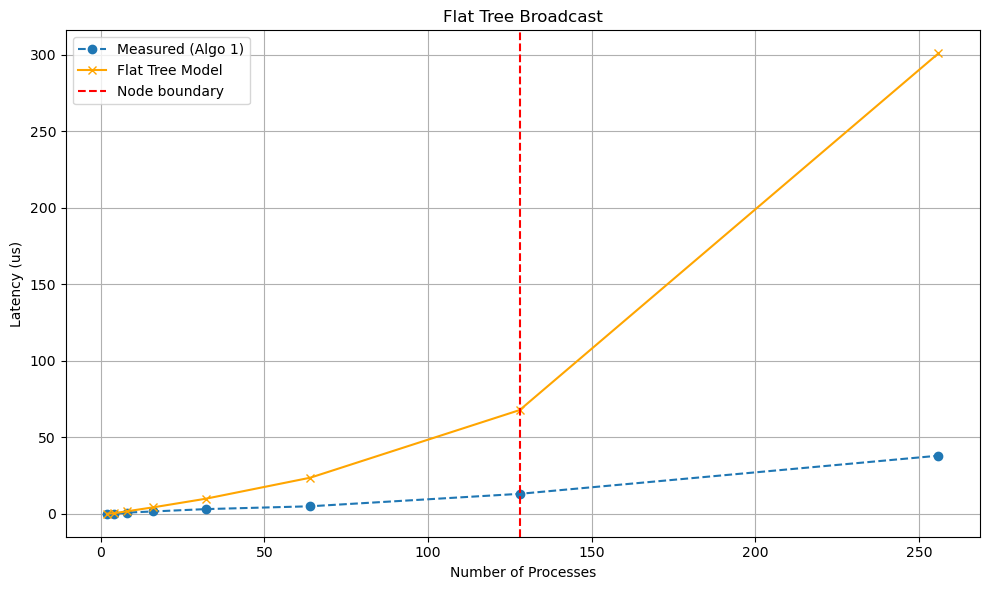

In [ ]:
df_plot = df_flat[df_flat["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]
df_plot["Flat Tree Model (us)"] = df_plot["Processes"].apply(model_flat_tree_latency)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Algo 1)")

plt.plot(df_plot["Processes"], df_plot["Flat Tree Model (us)"],
         marker='x', linestyle='-', color='orange', label="Flat Tree Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Flat Tree Broadcast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 

### Pipeline

In [ ]:
def model_pipeline_latency(P):
    if P <= 1:
        return 0
    # One segment must traverse the whole chain
    base_time = sum(latency_matrix[i][i+1] for i in range(P - 1))
    return base_time 

df_pipeline = pd.read_csv(bcast_files["Pipeline"])
df_pipeline.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

df_pipeline["Processes"] = pd.to_numeric(df_pipeline["Processes"], errors="coerce")
df_pipeline["Size"] = pd.to_numeric(df_pipeline["Size"], errors="coerce")
df_pipeline["Latency(us)"] = pd.to_numeric(df_pipeline["Latency(us)"], errors="coerce")

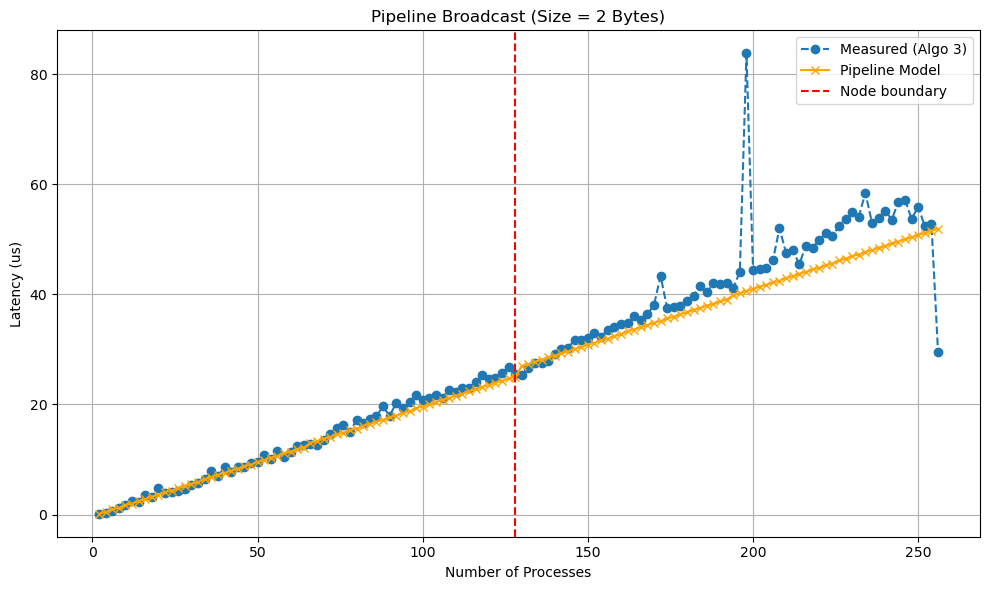

In [ ]:
size_chosen = 2
df_pipe_plot = df_pipeline[df_pipeline["Size"] == size_chosen].copy()
df_pipe_plot = df_pipe_plot[df_pipe_plot["Processes"] <= 256]

df_pipe_plot["Pipeline Model (us)"] = df_pipe_plot["Processes"].apply(model_pipeline_latency)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Algo 3)")
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Pipeline Model (us)"],
         marker='x', linestyle='-', color='orange', label="Pipeline Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Pipeline Broadcast (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Binomial tree

In [ ]:
df_binomial = pd.read_csv(bcast_files["Binomial"])
df_binomial.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

df_binomial["Processes"] = pd.to_numeric(df_binomial["Processes"], errors="coerce")
df_binomial["Size"] = pd.to_numeric(df_binomial["Size"], errors="coerce")
df_binomial["Latency(us)"] = pd.to_numeric(df_binomial["Latency(us)"], errors="coerce")



In [ ]:
def model_binomial_latency(P):
    if P <= 1:
        return 0
    steps = math.ceil(math.log2(P))
    
    # Model: assume latency increases geometrically by distance, starting at core 1
    # We'll approximate each step as a hop from core 0 to core 2^i (for i in steps)
    total = 0
    for i in range(steps):
        dist = 2**i
        if dist >= P:
            break
        total += get_latency(dist)
    
    return total 
    

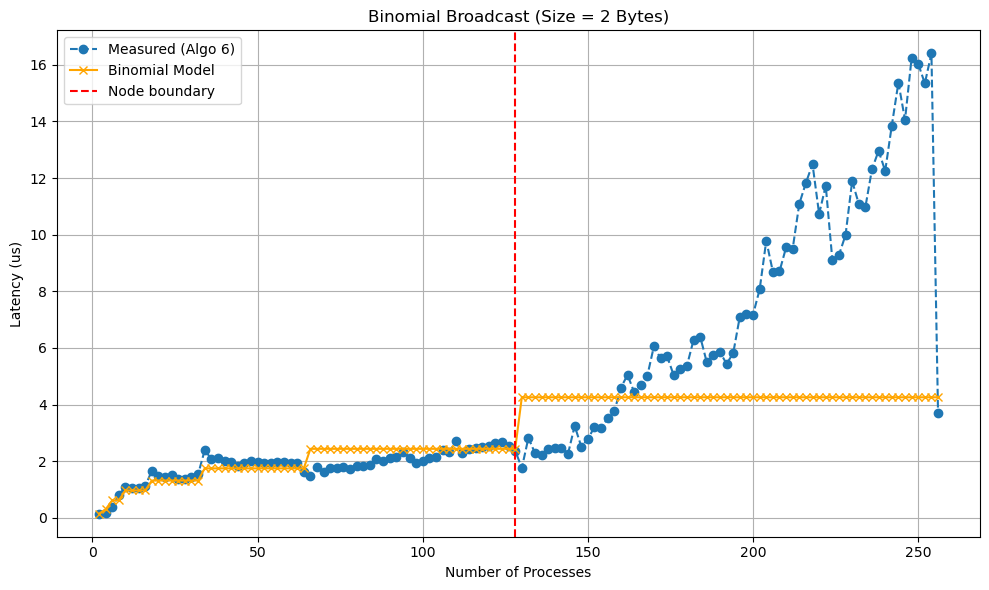

In [ ]:
size_chosen = 2
df_bin_plot = df_binomial[df_binomial["Size"] == size_chosen].copy()
df_bin_plot = df_bin_plot[df_bin_plot["Processes"] <= 256]

df_bin_plot["Binomial Model (us)"] = df_bin_plot["Processes"].apply(model_binomial_latency)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_bin_plot["Processes"], df_bin_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Algo 6)")
plt.plot(df_bin_plot["Processes"], df_bin_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Binomial Broadcast (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Chain

In [ ]:
def chain_bcast_model(P):
    if P <= 1:
        return 0
    hop = latency_matrix[1][0]  # all same distance assumed
    return hop * (P - 1)

In [ ]:
# Read the chain broadcast results
df_chain = pd.read_csv("../results_model/bcast_algo2.csv")
df_chain.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Clean up numeric types
df_chain["Processes"] = pd.to_numeric(df_chain["Processes"], errors="coerce")
df_chain["Size"] = pd.to_numeric(df_chain["Size"], errors="coerce")
df_chain["Latency(us)"] = pd.to_numeric(df_chain["Latency(us)"], errors="coerce")

# Filter for a fixed small message size
df_plot = df_chain[df_chain["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

# Add the model predictions
df_plot["Chain Model"] = df_plot["Processes"].apply(chain_bcast_model)


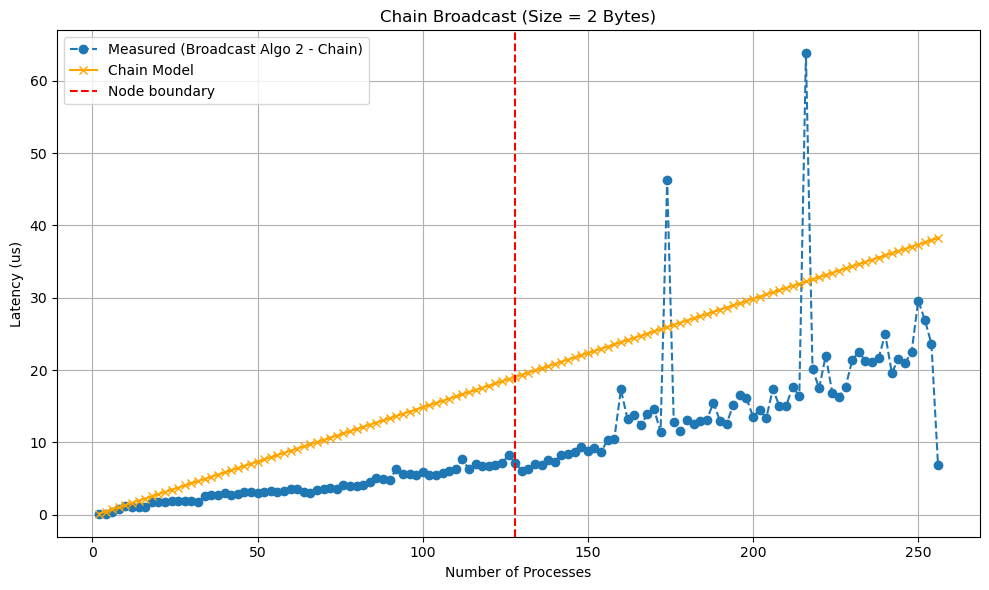

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Broadcast Algo 2 - Chain)")

plt.plot(df_plot["Processes"], df_plot["Chain Model"],
         marker='x', linestyle='-', color='orange', label="Chain Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Chain Broadcast (Size = 2 Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### All

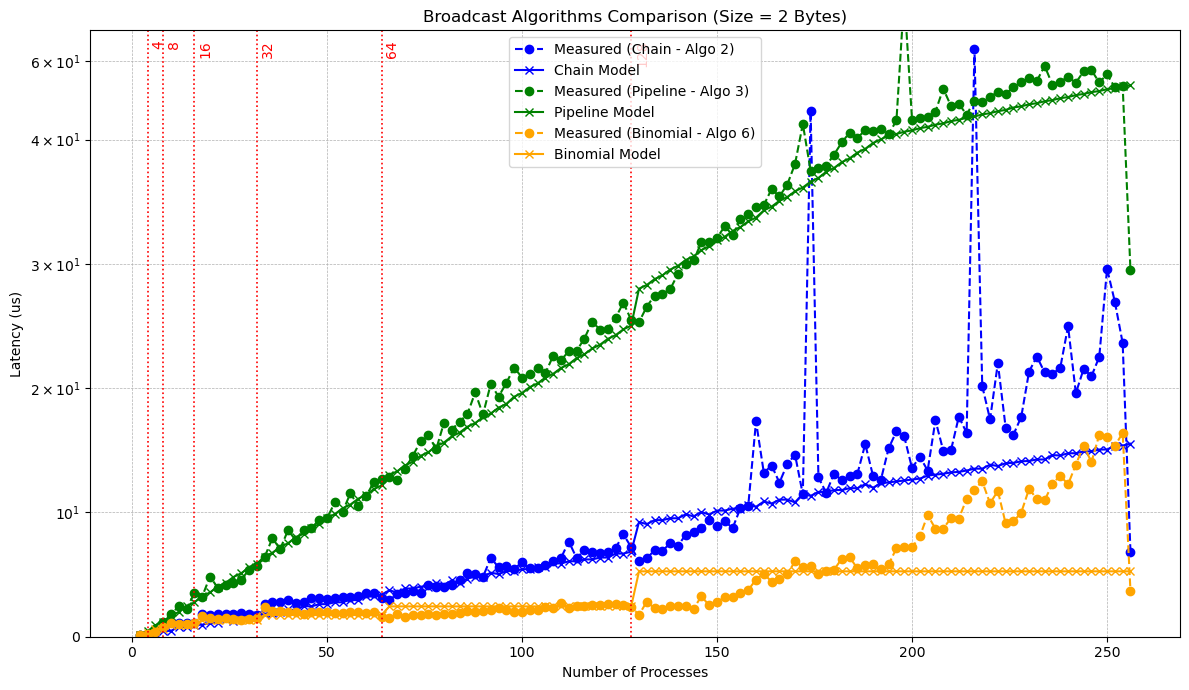

In [233]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Chain
plt.plot(df_chain_plot["Processes"], df_chain_plot["Latency(us)"],
         marker='o', linestyle='--', color='blue', label="Measured (Chain - Algo 2)")
plt.plot(df_chain_plot["Processes"], df_chain_plot["Chain Model (us)"],
         marker='x', linestyle='-', color='blue', label="Chain Model")

# Pipeline
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Latency(us)"],
         marker='o', linestyle='--', color='green', label="Measured (Pipeline - Algo 3)")
plt.plot(df_pipe_plot["Processes"], df_pipe_plot["Pipeline Model (us)"],
         marker='x', linestyle='-', color='green', label="Pipeline Model")

# Binomial
plt.plot(df_bin_plot["Processes"], df_bin_plot["Latency(us)"],
         marker='o', linestyle='--', color='orange', label="Measured (Binomial - Algo 6)")
plt.plot(df_bin_plot["Processes"], df_bin_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Model")

# Apply symlog scale with lower threshold and custom ticks
plt.yscale('symlog', linthresh=40)

# Set visible, meaningful ticks
custom_ticks = [0, 10, 20, 30, 40, 60, 80, 100, 200, 400, 800, 1600]
plt.yticks(custom_ticks)
plt.ylim(0, max(df_chain_plot["Latency(us)"].max(), df_bin_plot["Latency(us)"].max()) * 1.1)

# Add vertical lines at hierarchy boundaries (not in legend)
for y in [4, 8, 16, 32, 64, 128]:
    plt.axvline(y, color='red', linestyle=':', linewidth=1.2)
    plt.text(y + 1, plt.ylim()[1] * 0.95, f"{y}", color='red', rotation=90, va='top')

# Labels and style
plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Broadcast Algorithms Comparison (Size = 2 Bytes)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


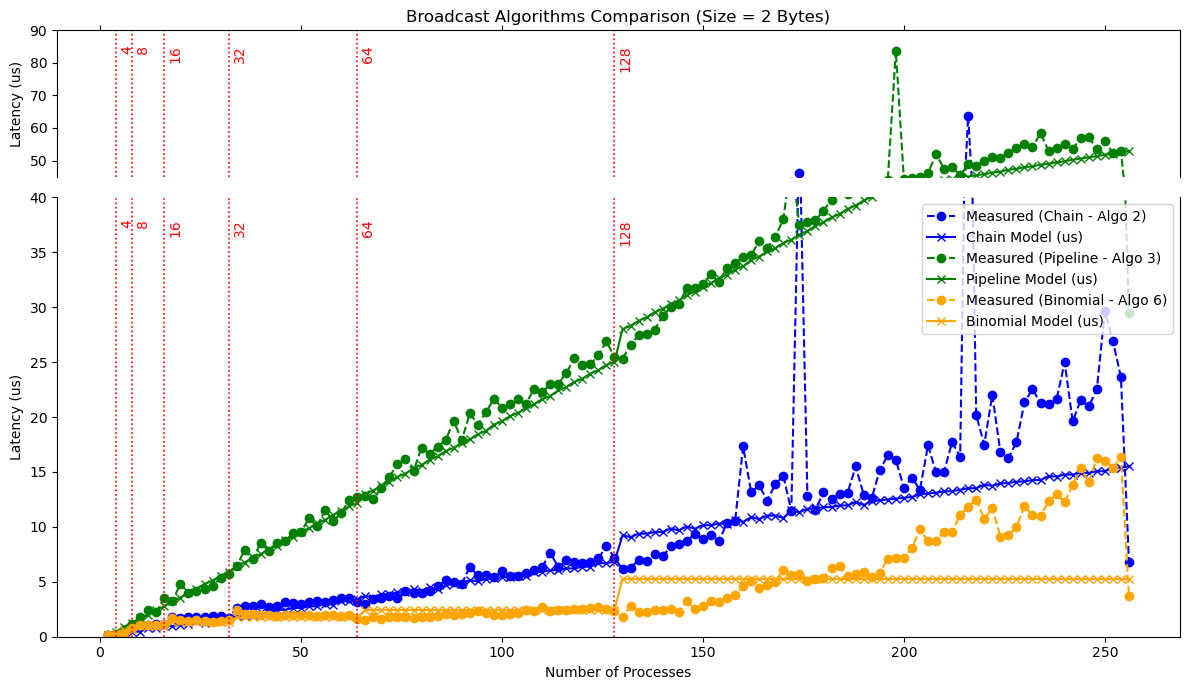

In [ ]:
import matplotlib.pyplot as plt

# Create the plot with a broken y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 7), gridspec_kw={'height_ratios': [1, 3]})

# Plot settings
def plot_algo(ax, df, label_meas, label_model, color):
    ax.plot(df["Processes"], df["Latency(us)"], marker='o', linestyle='--', color=color, label=label_meas)
    ax.plot(df["Processes"], df[label_model], marker='x', linestyle='-', color=color, label=label_model)

# Chain
plot_algo(ax1, df_chain_plot, "Measured (Chain - Algo 2)", "Chain Model (us)", 'blue')
plot_algo(ax2, df_chain_plot, "Measured (Chain - Algo 2)", "Chain Model (us)", 'blue')

# Pipeline
plot_algo(ax1, df_pipe_plot, "Measured (Pipeline - Algo 3)", "Pipeline Model (us)", 'green')
plot_algo(ax2, df_pipe_plot, "Measured (Pipeline - Algo 3)", "Pipeline Model (us)", 'green')

# Binomial
plot_algo(ax1, df_bin_plot, "Measured (Binomial - Algo 6)", "Binomial Model (us)", 'orange')
plot_algo(ax2, df_bin_plot, "Measured (Binomial - Algo 6)", "Binomial Model (us)", 'orange')

# Set y-limits for zoomed-in and out plots
ax1.set_ylim(45, 90)   # top
ax2.set_ylim(0, 40)    # bottom

# Horizontal breaks
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Add vertical dashed lines at architecture boundaries
for y in [4, 8, 16, 32, 64, 128]:
    for ax in (ax1, ax2):
        ax.axvline(y, color='red', linestyle=':', linewidth=1.2)
        ax.text(y + 1, ax.get_ylim()[1] * 0.95, f"{y}", color='red', rotation=90, va='top')

# Labeling
ax2.set_xlabel("Number of Processes")
ax1.set_ylabel("Latency (us)")
ax2.set_ylabel("Latency (us)")
ax1.set_title("Broadcast Algorithms Comparison (Size = 2 Bytes)")
ax2.legend()
plt.tight_layout()
plt.show()


## Reduce models 

### Linear

In [ ]:
df_reduce_linear = pd.read_csv("../results/reduce_algo1.csv")
df_reduce_linear.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Ensure types are clean
df_reduce_linear["Processes"] = pd.to_numeric(df_reduce_linear["Processes"], errors="coerce")
df_reduce_linear["Size"] = pd.to_numeric(df_reduce_linear["Size"], errors="coerce")
df_reduce_linear["Latency(us)"] = pd.to_numeric(df_reduce_linear["Latency(us)"], errors="coerce")


In [ ]:
def model_linear_reduce_latency(P):
    if P <= 1:
        return 0
    return sum(latency_matrix[i][0] for i in range(1, P))


size_chosen = 2
df_reduce_plot = df_reduce_linear[df_reduce_linear["Size"] == size_chosen].copy()
df_reduce_plot = df_reduce_plot[df_reduce_plot["Processes"] <= 256]

df_reduce_plot["Linear Reduce Model (us)"] = df_reduce_plot["Processes"].apply(model_linear_reduce_latency)
# Convert measured ms to µs if needed
df_reduce_plot["Latency(us)"] = df_reduce_plot["Latency(us)"] * 10


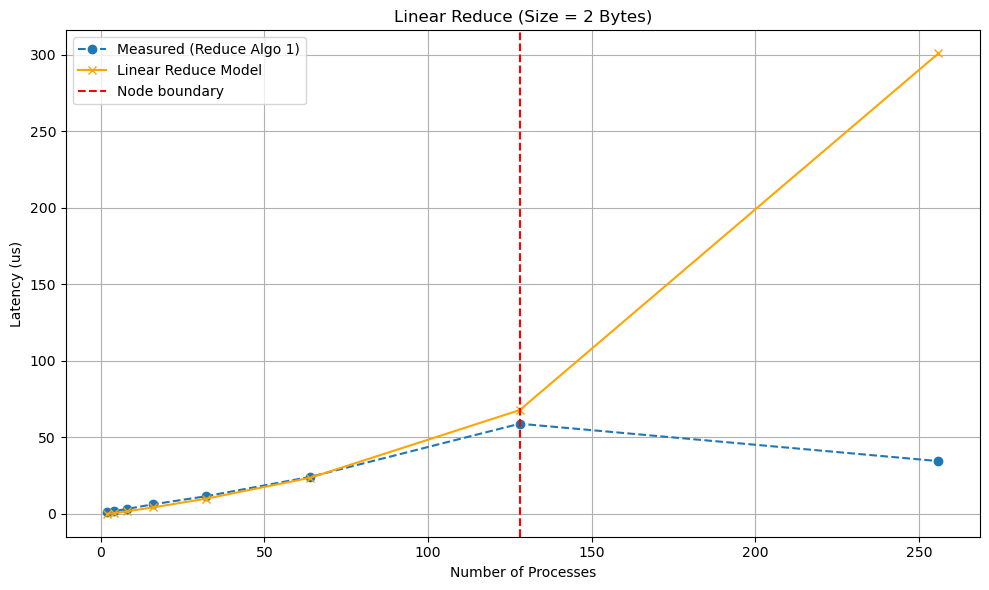

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df_reduce_plot["Processes"], df_reduce_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 1)")

plt.plot(df_reduce_plot["Processes"], df_reduce_plot["Linear Reduce Model (us)"],
         marker='x', linestyle='-', color='orange', label="Linear Reduce Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Linear Reduce (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Binomial

In [ ]:
def model_binomial_reduce_latency(P):
    if P <= 1:
        return 0
    total_latency = 0
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        src = stride
        dst = 0
        total_latency += latency_matrix[src][dst]
    return total_latency


In [ ]:
df_binomial = pd.read_csv("../results_model/reduce_algo5.csv")
df_binomial.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Make sure types are correct
df_binomial["Processes"] = pd.to_numeric(df_binomial["Processes"], errors="coerce")
df_binomial["Size"] = pd.to_numeric(df_binomial["Size"], errors="coerce")
df_binomial["Latency(us)"] = pd.to_numeric(df_binomial["Latency(us)"], errors="coerce")

# Filter for target size
df_binomial_plot = df_binomial[df_binomial["Size"] == 2].copy()

# Model: binomial tree has log₂(P) steps, each step ~ latency(2-hop)
df_binomial_plot["Binomial Model (us)"] = df_binomial_plot["Processes"].apply(
    lambda P: math.ceil(math.log2(P)) * get_latency(2)
)


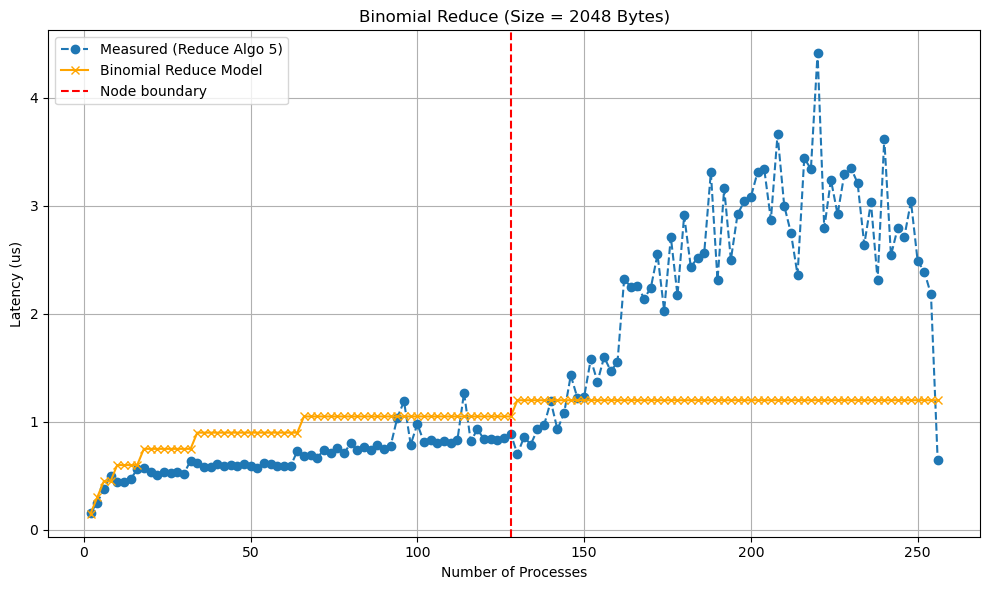

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(df_binomial_plot["Processes"], df_binomial_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 5)")
plt.plot(df_binomial_plot["Processes"], df_binomial_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Reduce Model")
plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Binomial Reduce (Size = 2048 Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rabenseifner



In [ ]:
import math

def rabenseifner_reduce_model(P):
    if P <= 1:
        return 0

    total_latency = 0

    # Phase 1: Reduce-Scatter (recursive halving)
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        # Estimate average latency between communicating partners
        latencies = []
        for rank in range(0, P, 2*stride):
            src = rank
            dst = rank + stride
            if dst < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)  # or sum(latencies)/len(latencies)

    # Phase 2: Gather (binomial tree)
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2*stride):
            src = rank + stride
            dst = rank
            if src < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)

    return total_latency


In [ ]:
df_rab = pd.read_csv("../results_model/reduce_algo7.csv")
df_rab.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]
df_rab["Processes"] = pd.to_numeric(df_rab["Processes"], errors="coerce")
df_rab["Size"] = pd.to_numeric(df_rab["Size"], errors="coerce")
df_rab["Latency(us)"] = pd.to_numeric(df_rab["Latency(us)"], errors="coerce")

# Filter for a specific message size (adjust as needed)
df_plot = df_rab[df_rab["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

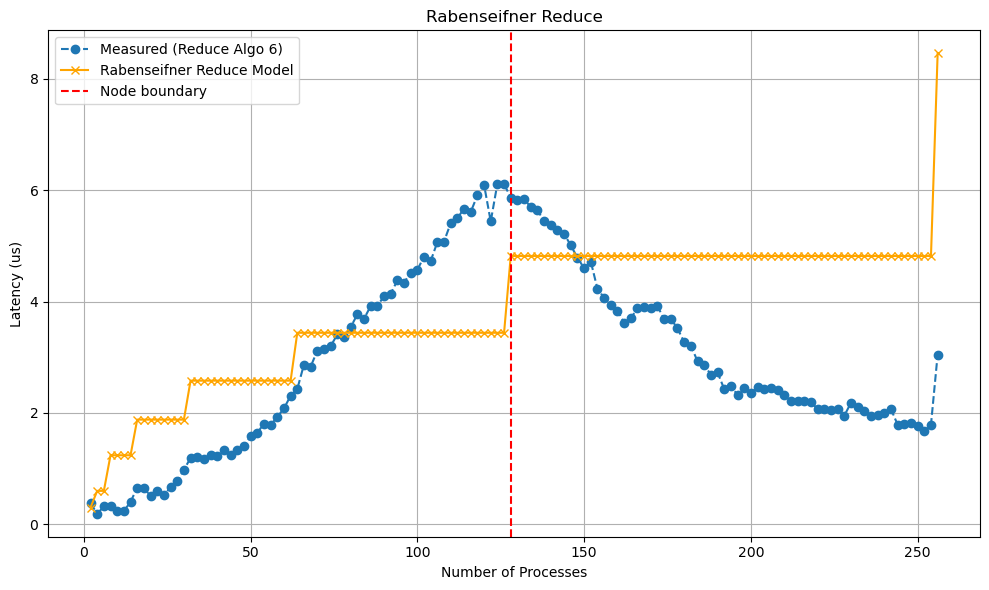

In [ ]:
df_plot["Rabenseifner Reduce Model"] = df_plot["Processes"].apply(rabenseifner_reduce_model)

plt.figure(figsize=(10, 6))
plt.plot(df_plot["Processes"], df_plot["Latency(us)"], marker='o', linestyle='--', label="Measured (Reduce Algo 6)")
plt.plot(df_plot["Processes"], df_plot["Rabenseifner Reduce Model"], marker='x', linestyle='-', color='orange', label="Rabenseifner Reduce Model")
plt.axvline(128, color='r', linestyle='--', label="Node boundary")
plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Rabenseifner Reduce")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 [      2       4       8      16      32      64     128     256     512
    1024    2048    4096    8192   16384   32768   65536  131072  262144
  524288 1048576]

### Binary

In [ ]:
def binary_reduce_model(P):
    if P <= 1:
        return 0

    total_latency = 0
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2 * stride):
            sender = rank + stride
            receiver = rank
            if sender < P:
                latencies.append(latency_matrix[sender][receiver])
        if latencies:
            total_latency += max(latencies)  # use max latency per level as approximation
    return total_latency

In [ ]:
df_binary = pd.read_csv("../results_model/reduce_algo4.csv")
df_binary.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Clean up numeric types
df_binary["Processes"] = pd.to_numeric(df_binary["Processes"], errors="coerce")
df_binary["Size"] = pd.to_numeric(df_binary["Size"], errors="coerce")
df_binary["Latency(us)"] = pd.to_numeric(df_binary["Latency(us)"], errors="coerce")


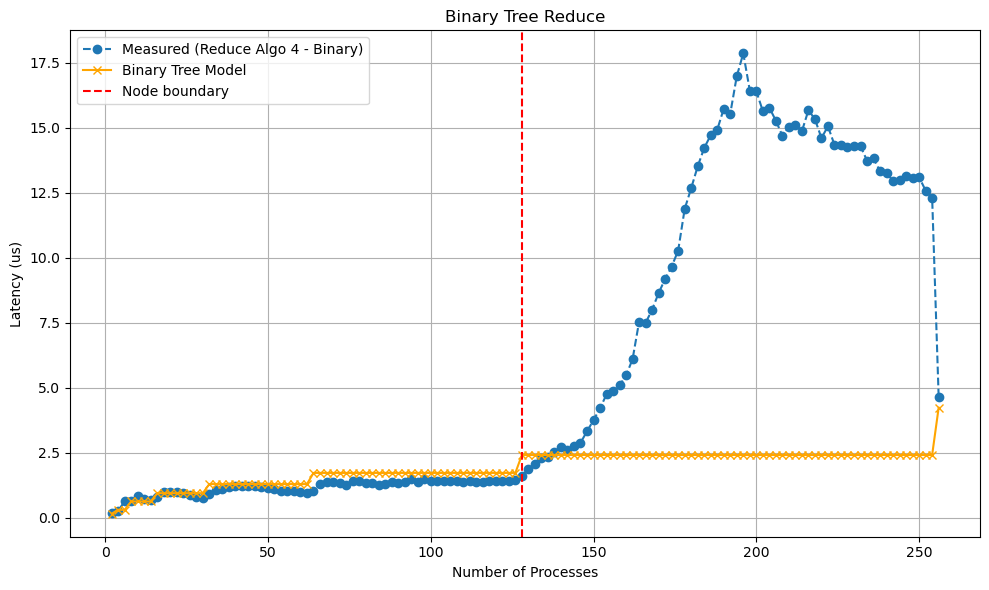

In [ ]:
df_plot = df_binary[df_binary["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

# Add model predictions
df_plot["Binary Reduce Model"] = df_plot["Processes"].apply(binary_reduce_model)

plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 4 - Binary)")

plt.plot(df_plot["Processes"], df_plot["Binary Reduce Model"],
         marker='x', linestyle='-', color='orange', label="Binary Tree Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Binary Tree Reduce")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Reduce models 

### Linear

In [36]:
df_reduce_linear = pd.read_csv("../results/reduce_algo1.csv")
df_reduce_linear.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Ensure types are clean
df_reduce_linear["Processes"] = pd.to_numeric(df_reduce_linear["Processes"], errors="coerce")
df_reduce_linear["Size"] = pd.to_numeric(df_reduce_linear["Size"], errors="coerce")
df_reduce_linear["Latency(us)"] = pd.to_numeric(df_reduce_linear["Latency(us)"], errors="coerce")


In [37]:
def model_linear_reduce_latency(P):
    if P <= 1:
        return 0
    return sum(latency_matrix[i][0] for i in range(1, P))


size_chosen = 2
df_reduce_plot = df_reduce_linear[df_reduce_linear["Size"] == size_chosen].copy()
df_reduce_plot = df_reduce_plot[df_reduce_plot["Processes"] <= 256]

df_reduce_plot["Linear Reduce Model (us)"] = df_reduce_plot["Processes"].apply(model_linear_reduce_latency)
# Convert measured ms to µs if needed
df_reduce_plot["Latency(us)"] = df_reduce_plot["Latency(us)"] * 10


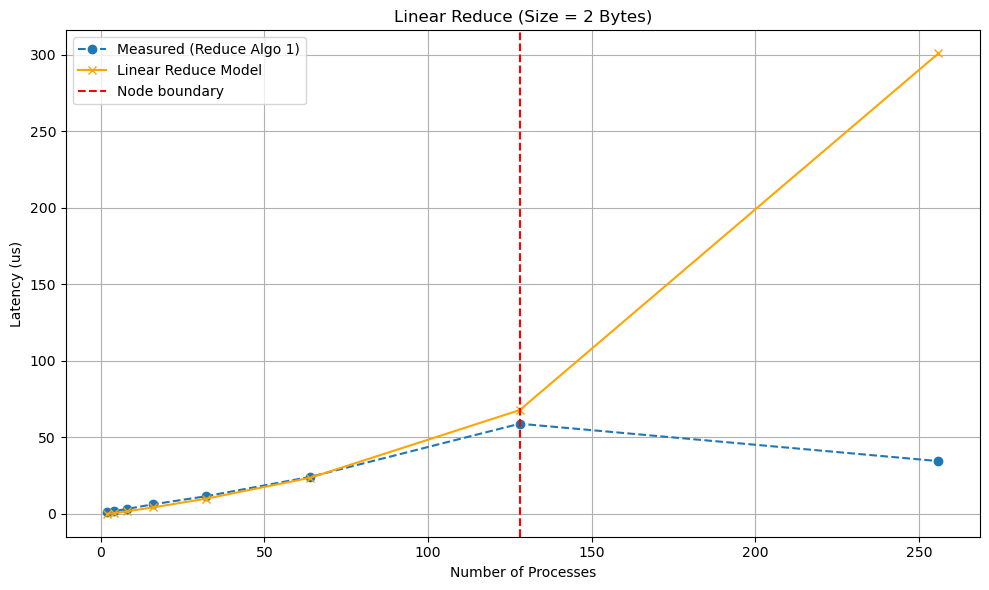

In [38]:

plt.figure(figsize=(10, 6))
plt.plot(df_reduce_plot["Processes"], df_reduce_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 1)")

plt.plot(df_reduce_plot["Processes"], df_reduce_plot["Linear Reduce Model (us)"],
         marker='x', linestyle='-', color='orange', label="Linear Reduce Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title(f"Linear Reduce (Size = {size_chosen} Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Binomial

In [299]:
def model_binomial_reduce_latency(P):
    if P <= 1:
        return 0

    total_latency = 0
    for i in range(int(math.log2(P))):
        mask = 1 << i
        latencies = []
        for rank in range(P):
            if rank & mask:
                src = rank
                dst = rank ^ mask
                if dst < P:
                    latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)
    return total_latency


In [300]:
df_binomial = pd.read_csv("../results_model/reduce_algo5.csv")
df_binomial.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]

# Make sure types are correct
df_binomial["Processes"] = pd.to_numeric(df_binomial["Processes"], errors="coerce")
df_binomial["Size"] = pd.to_numeric(df_binomial["Size"], errors="coerce")
df_binomial["Latency(us)"] = pd.to_numeric(df_binomial["Latency(us)"], errors="coerce")

# Filter for target size
df_binomial_plot = df_binomial[df_binomial["Size"] == 2].copy()

# Model: binomial tree has log₂(P) steps, each step ~ latency(2-hop)
df_binomial_plot["Binomial Model (us)"] = df_binomial_plot["Processes"].apply(model_binomial_reduce_latency)



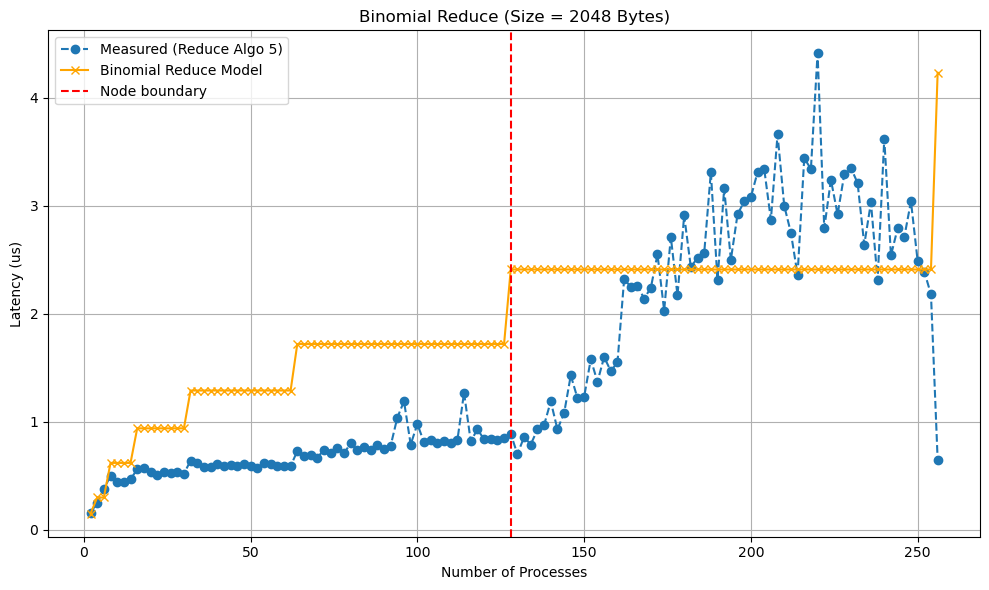

In [301]:
plt.figure(figsize=(10, 6))
plt.plot(df_binomial_plot["Processes"], df_binomial_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 5)")
plt.plot(df_binomial_plot["Processes"], df_binomial_plot["Binomial Model (us)"],
         marker='x', linestyle='-', color='orange', label="Binomial Reduce Model")
plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Binomial Reduce (Size = 2048 Bytes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rabenseifner



In [345]:
import math

def rabenseifner_reduce_model(P):
    if P <= 1:
        return 0

    total_latency = 0

    # Phase 1: Reduce-Scatter (recursive halving)
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        # Estimate average latency between communicating partners
        latencies = []
        for rank in range(0, P, 2*stride):
            src = rank
            dst = rank + stride
            if dst < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)  # or sum(latencies)/len(latencies)

    # Phase 2: Gather (binomial tree)
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2*stride):
            src = rank + stride
            dst = rank
            if src < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)

    return total_latency


In [346]:
df_rab = pd.read_csv("../results_model/reduce_algo7.csv")
df_rab.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]
df_rab["Processes"] = pd.to_numeric(df_rab["Processes"], errors="coerce")
df_rab["Size"] = pd.to_numeric(df_rab["Size"], errors="coerce")
df_rab["Latency(us)"] = pd.to_numeric(df_rab["Latency(us)"], errors="coerce")

# Filter for a specific message size (adjust as needed)
df_plot = df_rab[df_rab["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

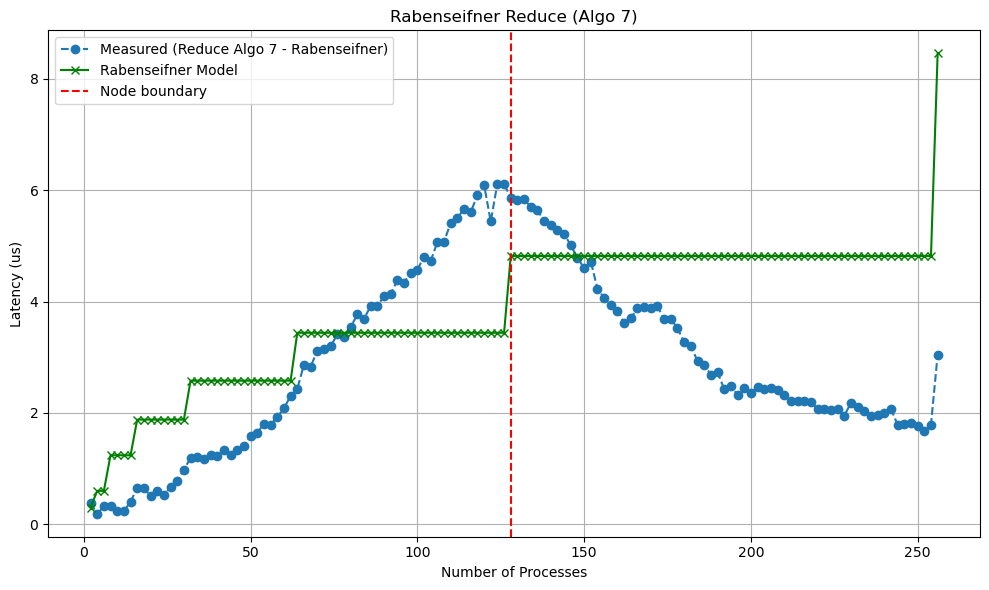

In [355]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Define simplified Rabenseifner model (returns only total latency) ===
def rabenseifner_reduce_model(P):
    if P <= 1:
        return 0

    total_latency = 0

    # Phase 1: Reduce-Scatter
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2 * stride):
            src = rank
            dst = rank + stride
            if dst < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)

    # Phase 2: Gather
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2 * stride):
            src = rank + stride
            dst = rank
            if src < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            total_latency += max(latencies)

    return total_latency



# === Load measured data ===
df_rab = pd.read_csv("../results_model/reduce_algo7.csv")
df_rab.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]
df_rab["Processes"] = pd.to_numeric(df_rab["Processes"], errors="coerce")
df_rab["Size"] = pd.to_numeric(df_rab["Size"], errors="coerce")
df_rab["Latency(us)"] = pd.to_numeric(df_rab["Latency(us)"], errors="coerce")

# === Filter for message size = 2 bytes ===
df_plot = df_rab[df_rab["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

# === Compute model values ===
df_plot["Rabenseifner Model"] = df_plot["Processes"].apply(rabenseifner_reduce_model)

# === Plot ===
plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 7 - Rabenseifner)")

plt.plot(df_plot["Processes"], df_plot["Rabenseifner Model"],
         marker='x', linestyle='-', color='green', label="Rabenseifner Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Rabenseifner Reduce (Algo 7)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


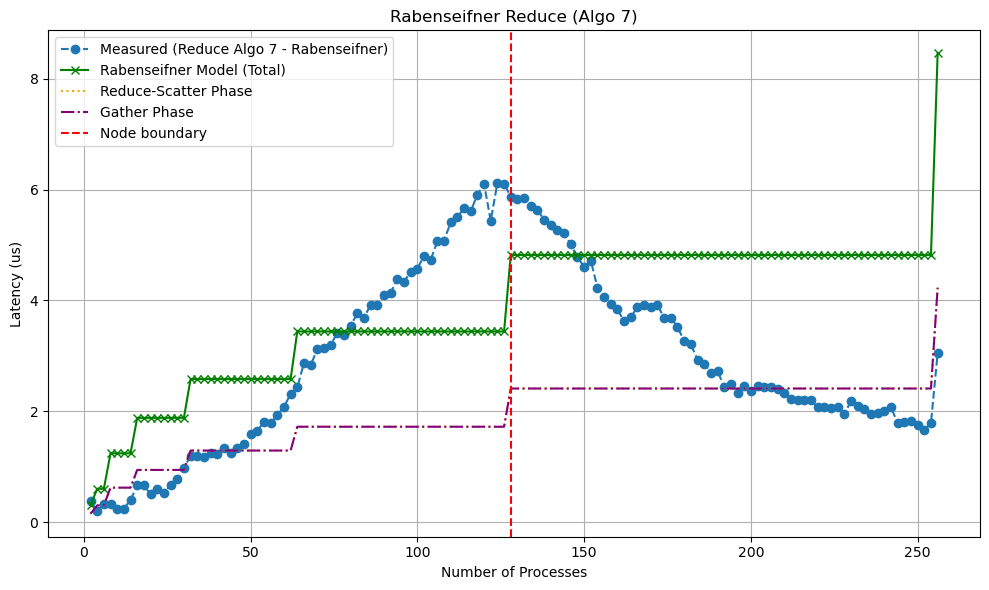

In [351]:

def rabenseifner_reduce_model(P):
    if P <= 1:
        return 0, 0, 0  # total, phase1, phase2

    phase1_latency = 0  # Reduce-Scatter
    phase2_latency = 0  # Gather

    # Phase 1: Reduce-Scatter (recursive halving)
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2 * stride):
            src = rank
            dst = rank + stride
            if dst < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            phase1_latency += max(latencies)

    # Phase 2: Gather (binomial tree)
    for i in range(int(math.log2(P))):
        stride = 2 ** i
        latencies = []
        for rank in range(0, P, 2 * stride):
            src = rank + stride
            dst = rank
            if src < P:
                latencies.append(latency_matrix[src][dst])
        if latencies:
            phase2_latency += max(latencies)

    total_latency = phase1_latency + phase2_latency
    return total_latency, phase1_latency, phase2_latency

# === Load measured data ===
df_rab = pd.read_csv("../results_model/reduce_algo7.csv")
df_rab.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]
df_rab["Processes"] = pd.to_numeric(df_rab["Processes"], errors="coerce")
df_rab["Size"] = pd.to_numeric(df_rab["Size"], errors="coerce")
df_rab["Latency(us)"] = pd.to_numeric(df_rab["Latency(us)"], errors="coerce")

# === Filter for a specific message size ===
df_plot = df_rab[df_rab["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

# === Apply model to each row ===
df_plot[["Rabenseifner Total", "Rabenseifner Phase1", "Rabenseifner Phase2"]] = df_plot["Processes"].apply(
    lambda P: pd.Series(rabenseifner_reduce_model(P))
)

# === Plot ===
plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 7 - Rabenseifner)")

plt.plot(df_plot["Processes"], df_plot["Rabenseifner Total"],
         marker='x', linestyle='-', color='green', label="Rabenseifner Model (Total)")

plt.plot(df_plot["Processes"], df_plot["Rabenseifner Phase1"],
         linestyle=':', color='orange', label="Reduce-Scatter Phase")

plt.plot(df_plot["Processes"], df_plot["Rabenseifner Phase2"],
         linestyle='-.', color='purple', label="Gather Phase")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")
plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Rabenseifner Reduce (Algo 7)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 [      2       4       8      16      32      64     128     256     512
    1024    2048    4096    8192   16384   32768   65536  131072  262144
  524288 1048576]

### Binary

In [324]:
def binary_reduce_model(num_ranks):
    ranks = list(range(num_ranks))

    def get_parent(child_rank):
        # Simple binary tree: parent of child_rank is (child_rank - 1) // 2
        return (child_rank - 1) // 2 if child_rank > 0 else None

    max_latency = 0

    # For each leaf, walk up to root and sum latencies
    for leaf in range(num_ranks):
        total = 0
        current = leaf
        while True:
            parent = get_parent(current)
            if parent is None:
                break
            total += latency_matrix[current][parent]
            current = parent
        max_latency = max(max_latency, total)

    return max_latency

In [325]:
df_binary = pd.read_csv("../results_model/reduce_algo4.csv")
df_binary.columns = ["Processes", "Size", "Algorithm", "Latency(us)"]


df_binary["Processes"] = pd.to_numeric(df_binary["Processes"], errors="coerce")
df_binary["Size"] = pd.to_numeric(df_binary["Size"], errors="coerce")
df_binary["Latency(us)"] = pd.to_numeric(df_binary["Latency(us)"], errors="coerce")


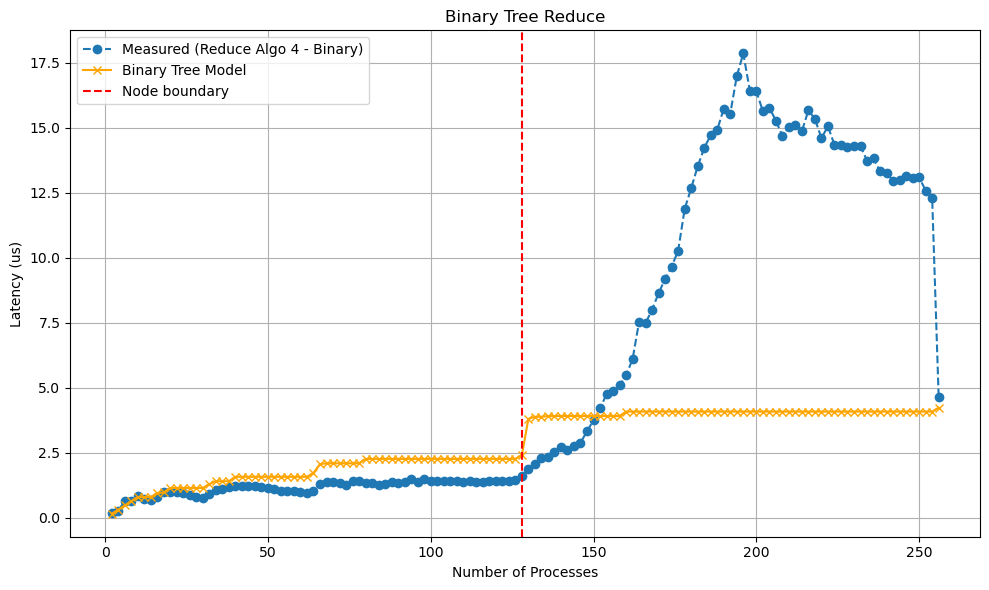

In [326]:
df_plot = df_binary[df_binary["Size"] == 2].copy()
df_plot = df_plot[df_plot["Processes"] <= 256]

# Add model predictions
df_plot["Binary Reduce Model"] = df_plot["Processes"].apply(binary_reduce_model)

plt.figure(figsize=(10, 6))

plt.plot(df_plot["Processes"], df_plot["Latency(us)"],
         marker='o', linestyle='--', label="Measured (Reduce Algo 4 - Binary)")

plt.plot(df_plot["Processes"], df_plot["Binary Reduce Model"],
         marker='x', linestyle='-', color='orange', label="Binary Tree Model")

plt.axvline(128, color='r', linestyle='--', label="Node boundary")

plt.xlabel("Number of Processes")
plt.ylabel("Latency (us)")
plt.title("Binary Tree Reduce")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### All

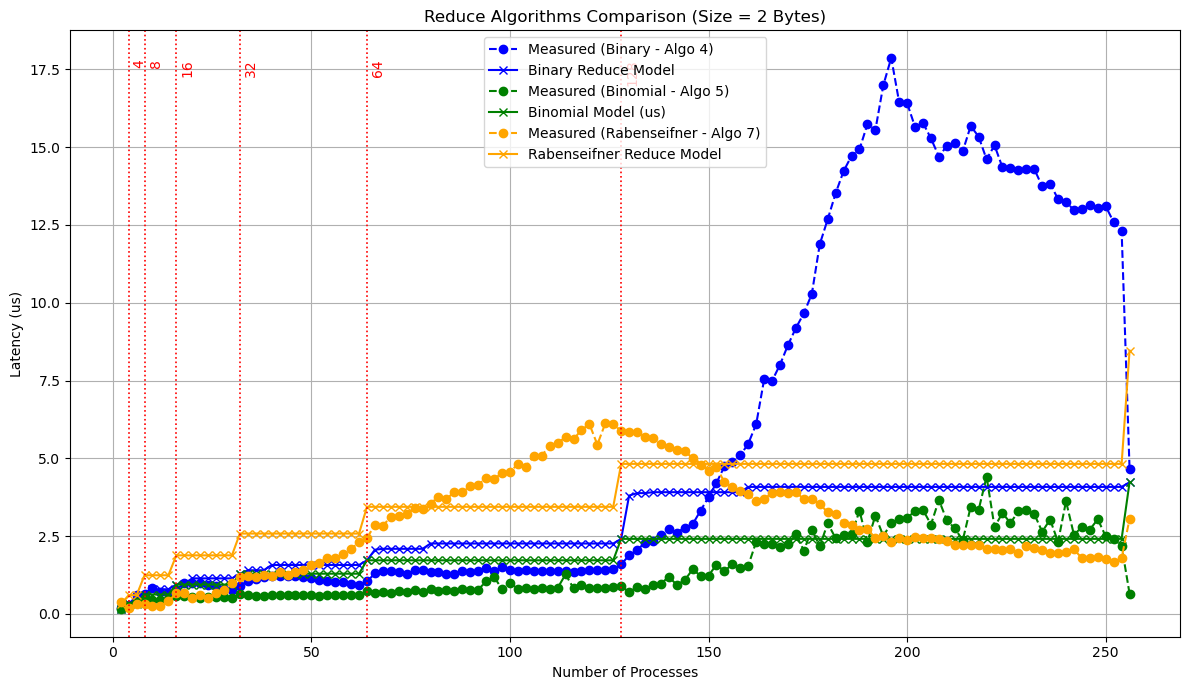

In [327]:
import matplotlib.pyplot as plt

# Prepare Binary Reduce Plot DataFrame
df_binary_plot = df_binary[df_binary["Size"] == 2].copy()
df_binary_plot = df_binary_plot[df_binary_plot["Processes"] <= 256]
df_binary_plot["Binary Reduce Model"] = df_binary_plot["Processes"].apply(binary_reduce_model)

# Prepare Binomial Reduce Plot DataFrame
df_binomial_plot = df_binomial[df_binomial["Size"] == 2].copy()
df_binomial_plot = df_binomial_plot[df_binomial_plot["Processes"] <= 256]
df_binomial_plot["Binomial Model (us)"] = df_binomial_plot["Processes"].apply(model_binomial_reduce_latency)

# Prepare Rabenseifner Reduce Plot DataFrame
df_rab_plot = df_rab[df_rab["Size"] == 2].copy()
df_rab_plot = df_rab_plot[df_rab_plot["Processes"] <= 256]
df_rab_plot["Rabenseifner Reduce Model"] = df_rab_plot["Processes"].apply(rabenseifner_reduce_model)

# Plotting function
def plot_algo(ax, df, label_meas, label_model, color):
    ax.plot(df["Processes"], df["Latency(us)"], marker='o', linestyle='--', color=color, label=label_meas)
    ax.plot(df["Processes"], df[label_model], marker='x', linestyle='-', color=color, label=label_model)

fig, ax = plt.subplots(figsize=(12, 7))

plot_algo(ax, df_binary_plot, "Measured (Binary - Algo 4)", "Binary Reduce Model", 'blue')
plot_algo(ax, df_binomial_plot, "Measured (Binomial - Algo 5)", "Binomial Model (us)", 'green')
plot_algo(ax, df_rab_plot, "Measured (Rabenseifner - Algo 7)", "Rabenseifner Reduce Model", 'orange')

# Vertical architecture lines
for y in [4, 8, 16, 32, 64, 128]:
    ax.axvline(y, color='red', linestyle=':', linewidth=1.2)
    ax.text(y + 1, ax.get_ylim()[1] * 0.95, f"{y}", color='red', rotation=90, va='top')

# Labels and legend
ax.set_xlabel("Number of Processes")
ax.set_ylabel("Latency (us)")
ax.set_title("Reduce Algorithms Comparison (Size = 2 Bytes)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

